In [1]:
#!/usr/bin/env python3.6.4
# -*-coding:UTF-8 -*
import logging
import random
import os

import csv
import numpy as np
import pandas as pd
import pickle


from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

from tensorflow import keras
import os
import re

"""
COPYRIGHT A2IM-ROBOTADVISORS & INSTITUT LOUIS BACHELIER
DEVELOPPER : MELS-ILB 
DATE : 07-04-2019
DESCRIPTION :
THIS MODULE BUILD A MODEL FOR KAGGLE CHALLENGE
"""

####################
###### PATHS #######
####################

# Set the output directory for saving model file
BERT_MODEL_NAME = 'bert_predicter'
OUTPUT_DIR = 'OUTPUT_DIR_'+BERT_MODEL_NAME #@param {type:"string"}

#####################
##### LOAD DATA #####
#####################

tags = ['target', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white',
       'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit']

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

all_identity_columns = ['asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white'] # True / False

toxicity_subtypes_columns = ['severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat'] # True / False

articles_info_columns = ['rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit'] # Rating = approved/rejected  others = number of votes

TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

this_folder = '/media/ubuntu/Data/kaggle-toxicity' #os.path.dirname(os.path.abspath(__file__))
path_input = this_folder+'/jigsaw-unintended-bias-in-toxicity-classification/'
path_model = this_folder+'/OUTPUT_DIR_MODEL_FILES/'
path = os.path.join(path_input,'train.csv')
path_test = os.path.join(path_input,'test.csv')

def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

def read_dataset(path,test_size,data_size_threshold=5000):
    initial_dataset = pd.read_csv(path, header=0, sep=",").sample(data_size_threshold)
    # ADD to the training other tags
    # ADD different encoding for comment_text
    dataset = convert_dataframe_to_bool(initial_dataset)
    
    X = dataset.comment_text
    Y = np.array([dataset.target.tolist(), dataset.male.tolist(), dataset.female.tolist(), 
                        dataset.homosexual_gay_or_lesbian.tolist(), dataset.christian.tolist(), dataset.jewish.tolist(), dataset.muslim.tolist(), 
                        dataset.black.tolist(), dataset.white.tolist(), dataset.psychiatric_or_mental_illness.tolist()])

    x_train, x_test, y_train, y_test = train_test_split(X, np.transpose(Y), random_state=0, test_size=test_size)
    train = np.concatenate((np.array(x_train).reshape(-1,1),np.array(y_train)),axis=1)
    test = np.concatenate((np.array(x_test).reshape(-1,1),np.array(y_test)),axis=1)
    return pd.DataFrame(train, columns=['comment_text','target']+identity_columns), pd.DataFrame(test,columns=['comment_text','target']+identity_columns)


W0417 14:52:11.437590 140404282844992 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [3]:
# Load data from csv files %%% data full size : 1804874
print(f'Beginning loading data!')
current_time = datetime.now()
train, test = read_dataset(path,test_size=0.30, data_size_threshold=1804874)
print("Loading data took time ", datetime.now() - current_time)

Beginning loading data!
Loading data took time  0:00:46.279391


In [4]:
train.shape

(1263411, 11)

In [5]:
train.columns


Index(['comment_text', 'target', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness'],
      dtype='object')

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [10]:
train.columns

Index(['comment_text', 'target', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness'],
      dtype='object')

Text(0.5, 1.0, 'Number of toxic/non-toxic label')

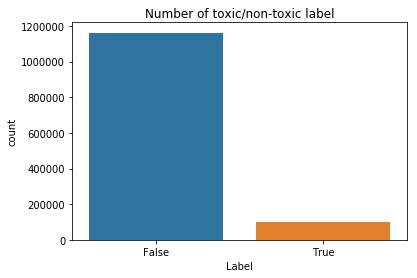

In [12]:
sns.countplot(train.target.values)
plt.xlabel('Label')
plt.title('Number of toxic/non-toxic label')

In [14]:
X_train = train.comment_text.values
Y_train = train.target.values

X_test = test.comment_text.values
Y_test = test.target.values

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = Y_test.reshape(-1,1)

In [19]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [21]:
sequences_matrix

array([[  0,   0,   0, ..., 522, 235,  19],
       [  0,   0,   0, ...,  29, 159,  52],
       [  0,   0,   0, ..., 230,  19,  88],
       ...,
       [  0,   0,   0, ...,  63,  15,  16],
       [  0,   0,   0, ...,   5, 372, 459],
       [  0,   0,   0, ..., 700,  60,  84]], dtype=int32)

In [22]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [23]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


W0417 15:49:01.654307 140404282844992 deprecation.py:323] From /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0417 15:49:02.497312 140404282844992 deprecation.py:506] From /home/ubuntu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))